### Name: Young Suh
### Student ID: 015391571
### Professor: Gautam Krishna
### Course: Reinforcement Learning (CMPE260)
### Title: Investigating the Effect of Logstd, Single/Dual-Critic, Depth of Networks in PPO for Autonomous Driving
### Date: May 18, 2025

### I would like to thank ChatGPT for guidance and support in coding and debugging throughout the development of this project. Additionally, this project was conducted using the CarRacing-v3 environment provided by OpenAI Gymnasium, which served as the simulation platform for training and evaluation.

In [5]:
import os
import gymnasium as gym
import numpy as np
import torch

import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import json


# Custom Neural Network for Policy and Value Functions
class PolicyNetwork(nn.Module):
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )
        n_flatten = self._get_flattened_size(observation_space)
        action_dim = action_space.shape[0]

        self.fc_policy_mean = nn.Sequential(
            nn.Linear(n_flatten, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Tanh()  # Ensure action values are bounded
        )
        self.fc_policy_logstd = nn.Parameter(torch.zeros(action_dim) + 1.3)  # Increase initial exploration

        # Primary Critic
        self.fc_value1 = nn.Sequential(
            nn.Linear(n_flatten, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # Auxiliary Critic
        self.fc_value2 = nn.Sequential(
            nn.Linear(n_flatten, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def _get_flattened_size(self, observation_space):
        with torch.no_grad():
            sample_input = torch.zeros((1, 3, 96, 96))
            return self.conv(sample_input).view(1, -1).size(1)

    def forward(self, x):
        x = self.conv(x)
        policy_mean = self.fc_policy_mean(x)
        policy_logstd = self.fc_policy_logstd.expand_as(policy_mean)
        value1 = self.fc_value1(x)
        value2 = self.fc_value2(x)
        return policy_mean, policy_logstd, value1, value2

# PPO Agent Implementation
class PPOAgent:
    def __init__(self, env_id, lr=3e-4, gamma=0.995, lam=0.95, clip_epsilon=0.2, update_epochs=10, batch_size=64):
        self.env = gym.make(env_id, render_mode="human")
        self.gamma = gamma  # Encourage long-term planning
        self.lam = lam
        self.clip_epsilon = clip_epsilon
        self.update_epochs = update_epochs  # Reduce update epochs to prevent instability
        self.batch_size = batch_size

        obs_space = self.env.observation_space
        act_space = self.env.action_space

        self.policy_net = PolicyNetwork(obs_space, act_space)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr, eps=1e-5, weight_decay=1e-4)  # Prevent overfitting
        self.total_reward_list = np.array([])
        self.best_mean_reward = -70

    def compute_advantages(self, rewards, values, dones):
        advantages = []
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * values[t + 1] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.lam * (1 - dones[t]) * gae
            advantages.insert(0, gae)
        return np.array(advantages)
    def collect_trajectory(self, steps):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy_net.to(device)  # Move the policy network to the selected device
        obs, _ = self.env.reset()
        obs_list, actions, rewards, dones, values, log_probs = [], [], [], [], [], []
        total_reward = 0
        
        for step in range(steps):
            obs = obs.astype(np.float16) / 255.0
            obs_tensor = torch.tensor(obs, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

            policy_mean, policy_logstd, value1, value2 = self.policy_net(obs_tensor)
            policy_std = policy_logstd.exp()
            dist = Normal(policy_mean, policy_std)

            action = dist.sample()
            action = action.squeeze().detach().cpu().numpy()
            #action = np.clip(action, self.env.action_space.low, self.env.action_space.high)

            obs_list.append(obs.astype(np.float16))
            actions.append(action)
            values.append(torch.min(value1, value2).item())
            log_probs.append(dist.log_prob(torch.tensor(action, device=device)).sum().item())

            obs, reward, done, truncated, _ = self.env.step(action)
            self.env.render()
         
            rewards.append(reward)
            total_reward += reward
            dones.append(done or truncated)

            if done or truncated:
                print(f"Episode ended with total reward: {total_reward:.2f}")
                self.total_reward_list = np.append(self.total_reward_list,[total_reward])
                total_reward = 0
                obs, _ = self.env.reset()

            #if step % 1000 == 0:
            #    print(f"Collected {step}/{steps} steps")

        obs_tensor = torch.tensor(obs, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
        _, _, final_value1, final_value2 = self.policy_net(obs_tensor)
        values.append(torch.min(final_value1, final_value2).item())

        return (
            np.array(obs_list),
            np.array(actions),
            np.array(rewards),
            np.array(dones),
            np.array(values),
            np.array(log_probs),
        )    
    def update(self, obs, actions, log_probs_old, returns, advantages):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy_net.to(device)

        obs = torch.tensor(obs, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        actions = torch.tensor(actions, dtype=torch.float32).to(device)
        log_probs_old = torch.tensor(log_probs_old, dtype=torch.float32).to(device)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(device)

        for _ in range(self.update_epochs):
            for idx in range(0, len(obs), self.batch_size):
                batch_obs = obs[idx:idx + self.batch_size]
                batch_actions = actions[idx:idx + self.batch_size]
                batch_log_probs_old = log_probs_old[idx:idx + self.batch_size]
                batch_returns = returns[idx:idx + self.batch_size]
                batch_advantages = advantages[idx:idx + self.batch_size]

                # Forward pass through actor and both critics
                policy_mean, policy_logstd, value1, value2 = self.policy_net(batch_obs)
                policy_std = policy_logstd.exp()
                dist = Normal(policy_mean, policy_std)

                log_probs = dist.log_prob(batch_actions).sum(dim=-1)
                entropy = dist.entropy().mean()

                ratio = (log_probs - batch_log_probs_old).exp()
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * batch_advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                # Separate loss for each critic
                value1_loss = (batch_returns - value1.squeeze()).pow(2).mean()
                value2_loss = (batch_returns - value2.squeeze()).pow(2).mean()
                value_loss = value1_loss + value2_loss

                # Total loss
                loss = policy_loss + 0.5 * value_loss - 0.02 * entropy

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    
    def train(self, total_timesteps, update_freq=5000):  # Update every 10,000 steps
        self.best_mean_reward = -float('inf')  # Initialize best reward tracking  # Update every 10,000 steps
        for step in range(0, total_timesteps, update_freq):
            obs_list, actions, rewards, dones, values, log_probs = self.collect_trajectory(update_freq)
            advantages = self.compute_advantages(rewards, values, dones)
            advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)  # Normalize advantages
            returns = advantages + values[:-1]
            mean_reward = np.mean(rewards)
            print(f"Total reward for training batch at step {step + update_freq}: {sum(rewards):.2f}, Mean Total_Reward: {mean_reward*1000:.2f}")
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                self.save(os.path.join(save_dir, f"ppo_best_model{step + update_freq}"))
                #print(f"New best model saved with mean reward: {self.best_mean_reward:.2f}")
            print("Training in progress...")
            self.update(obs_list, actions, log_probs, returns, advantages)
            del obs_list, actions, rewards, dones, values, log_probs
            torch.cuda.empty_cache()  # Clear GPU memory if using CUDA
        print("Training complete.")

    def save(self, filename="ppo_agent.pth2"):
        torch.save(self.policy_net.state_dict(), filename)
        print(f"Model saved to {filename}")

    def load(self, filename="ppo_agent.pth2"):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy_net.load_state_dict(torch.load(filename, map_location=device))
        self.policy_net.to(device)
        print(f"Model loaded from {filename} onto {device}")
    # revised evalutiona    

    def evaluate(self, episodes=20):
        env = gym.make("CarRacing-v3", render_mode="human")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy_net.to(device)

        success_threshold = 700
        reward_list = []
        episode_lengths = []
        successes = 0

        for ep in range(episodes):
            obs, _ = env.reset()
            done = False
            total_reward = 0
            length = 0

            while not done:
                obs = obs.astype(np.float16) / 255.0
                obs_tensor = torch.tensor(obs, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
                with torch.no_grad():
                    policy_mean, policy_logstd, _,_ = self.policy_net(obs_tensor)
                    action = policy_mean.squeeze().cpu().numpy()

                policy_std = policy_logstd.exp()
                dist = Normal(policy_mean, policy_std)

                action = dist.sample().squeeze().cpu().numpy()              
                obs, reward, done, truncated, _ = env.step(action)
                total_reward += reward
                length += 1
                if done or truncated:
                    print(f"Episode {ep + 1}: Total Reward: {total_reward:.2f}")
                    break

            reward_list.append(total_reward)
            episode_lengths.append(length)
            if total_reward > success_threshold:
                successes += 1

        env.close()
        print("Mean Reward:", np.mean(reward_list))
        print("Std. Dev:", np.std(reward_list))
        print("Success Rate:", successes / episodes * 100, "%")
        print("Avg. Episode Length:", np.mean(episode_lengths))
        print("Completion Rate:", sum(l == 1000 for l in episode_lengths) / episodes * 100, "%")
        


In [ ]:
# Main Program
if __name__ == "__main__":
    env_id = "CarRacing-v3"
    agent = PPOAgent(env_id)
    save_dir = "./2Nppo_agent_improved_57_100_2_logstd1.3R_critic seperate update"
    os.makedirs(save_dir, exist_ok=True)
    print("Training agent...")
    agent.train(total_timesteps=900000)

    agent.save(os.path.join(save_dir, "ppo_final_model_two critics"))
    print("Training completed. Model saved.")

    array_list=agent.total_reward_list.tolist()
    with open(os.path.join(save_dir, "array_57.json"), 'w') as file:
        json.dump(array_list, file)

In [6]:
   # Load and evaluate the best 
env_id = "CarRacing-v3"
agent = PPOAgent(env_id)
agent.load("./2Nppo_agent_improved_57_100_2_logstd1.3R_critic seperate update/ppo_best_model765000")
print("Evaluating the best saved model...")
agent.evaluate(episodes=20)

C:\Users\sangh\AppData\Local\Temp\ipykernel_26440\970635073.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.policy_net.load_state_dict(torch.load(filename, map_lo

Model loaded from ./2Nppo_agent_improved_57_100_2_logstd1.3R_critic seperate update/ppo_best_model765000 onto cuda
Evaluating the best saved model...
Episode 1: Total Reward: 534.24
Episode 2: Total Reward: 879.66
Episode 3: Total Reward: 907.80
Episode 4: Total Reward: 728.95
Episode 5: Total Reward: 887.26
Episode 6: Total Reward: 906.30
Episode 7: Total Reward: 915.80
Episode 8: Total Reward: 362.84
Episode 9: Total Reward: 850.88
Episode 10: Total Reward: 393.90
Episode 11: Total Reward: 837.06
Episode 12: Total Reward: 837.09
Episode 13: Total Reward: 871.43
Episode 14: Total Reward: 896.50
Episode 15: Total Reward: 906.50
Episode 16: Total Reward: 922.30
Episode 17: Total Reward: 698.70
Episode 18: Total Reward: 866.29
Episode 19: Total Reward: 911.40
Episode 20: Total Reward: 738.24
Mean Reward: 792.6569036104127
Std. Dev: 167.01006829371676
Success Rate: 80.0 %
Avg. Episode Length: 964.95
Completion Rate: 70.0 %


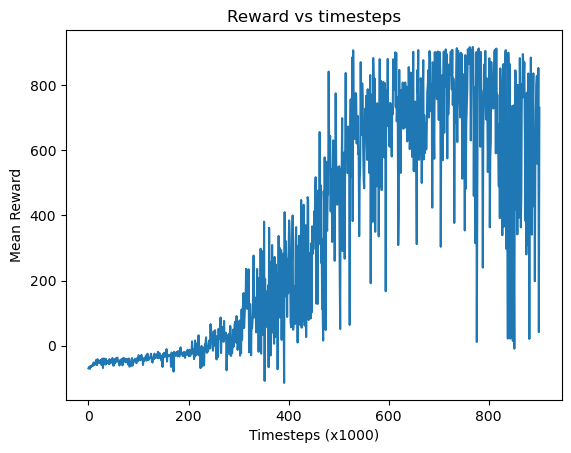

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
with open('./2Nppo_agent_improved_57_100_2_logstd1.3R_critic seperate update/array_57.json', 'r') as file: 
    loaded_list = json.load(file) # Converting the list back to a NumPy array 
loaded_array = np.array(loaded_list) 
#print(loaded_array) # O

plt.plot(loaded_array)
plt.title("Reward vs timesteps")
plt.xlabel("Timesteps (x1000)")
plt.ylabel("Mean Reward")
plt.show()